# Spectrogram of Seismic Time Series

In [ ]:
import torch

Plots a nice spectrogram with an especially nice time axis.

In [1]:
import obspy
import numpy as np
from obspy import UTCDateTime
import pandas as pd
import os
import math
import matplotlib.pyplot as plt

In [2]:
# read data
st_read = obspy.read('../data/channel*')
st_read

1 Trace(s) in Stream:
... | 2019-07-05T13:12:20.000000Z - 2019-07-08T18:35:21.999000Z | 1000.0 Hz, 278582000 samples

In [33]:
# trim the stream to a given start and end time
st = st_read.copy()
st = st.trim(starttime=UTCDateTime('2019-07-05T23:37'), endtime=UTCDateTime('2019-07-07T02:03'), pad=True)
st

1 Trace(s) in Stream:
... | 2019-07-05T23:37:00.000000Z - 2019-07-07T02:03:00.000000Z | 1000.0 Hz, 95160001 samples

In [34]:
# select a trace for the Spectrogram
tr = st[0]
tr

... | 2019-07-05T23:37:00.000000Z - 2019-07-07T02:03:00.000000Z | 1000.0 Hz, 95160001 samples

In [35]:
# for quick spectrogram plotting with ~1000 bins
def calc_NFFT(tr, power_of_2=False):
    '''calculate meaningful number of fourier samples for spectrogram'''
    fs = tr.stats.sampling_rate #sampling rate
    s_time = tr.stats.starttime
    e_time = tr.stats.endtime
    seconds = e_time - s_time
    NFFT = int(fs * seconds/1000) # results in ~1000 bins
    if power_of_2:
        NFFT = int(2**(math.floor(math.log(NFFT, 2)))) # power of 2 < than original value
    print(r'NFFT={} samples, equivalent to {} seconds'.format(NFFT, NFFT/fs))
    return NFFT 

NFFT = calc_NFFT(tr, power_of_2=True)

NFFT=65536 samples, equivalent to 65.536 seconds


In [36]:
# calculate the spectrogram
def calc_spec(tr, 
              NFFT=NFFT,
              noverlap=0,         # overlap in samples
              detrend='linear',   # detrending before taking fourier transform
              mode='psd',         # 'psd', 'magnitude', 'angle', 'phase'
              scale_by_freq=True, # unit/Hz
              scale='dB',         # 'linear', 'dB'
              **kwargs):
    '''calculates a spectrogram from an obspy trace'''
    
    data = tr.data
    fs = tr.stats.sampling_rate #sampling rate
    Pxx, freqs, bins, _ = plt.specgram(data, 
                                    NFFT=NFFT, 
                                    Fs=fs, 
                                    noverlap=noverlap,
                                    detrend=detrend, 
                                    mode=mode,
                                    scale_by_freq=scale_by_freq,
                                    scale=scale,
                                    **kwargs)
    plt.close() # for execution in Jupyter Notebook/Lab
    return Pxx, freqs, bins, tr.stats

Pxx, freqs, bins, stats = calc_spec(tr)#, NFFT=int(tr.stats.sampling_rate*600))

In [37]:
# some little helper functions that a necessary for the 'plot_spectro' function in the next cell
def x_tick_locs(stime, etime):
    '''calculate where to put x-ticks'''
    fmtfreq_list = {'years':['1YS'],
                     'months':['6MS','1MS'],
                     'days':['10d','5d','1d'],
                     'hours':['12h','6h','3h','1h'],
                     'minutes':['30min','15min','10min','5min','1min'],
                     'seconds':['30s','15s','10s','5s','1s']}

    for key in fmtfreq_list.keys():
        for value in fmtfreq_list[key]:
            daterange = pd.date_range(stime, etime+pd.Timedelta('1d'), 
                          freq=value, normalize=True)
            daterange = [t for t in daterange if t>=stime if t<=etime]
            if len(daterange)<6:
                continue
            else:
                return key, daterange 
            
def x_labels_fmt(key, same_superior):
    '''x-ticks and axis formatting'''
    # if no change of superior unit
    if same_superior:
        fmtlabels_list = {'years':('%Y', ('', '', '[Year]')),
                       'months':('%b', ('of', '%Y', '[Month]')),
                       'days':('%-d %b', ('of', '%Y' '[Day Month]')),
                       'hours':('%H:%M', ('of', '%-d %b %Y', '[Hour:Minute]')),
                       'minutes':('%H:%M', ('of', '%-d %b %Y', '[Hour:Minute]')),
                       'seconds':('%H:%M:%S', ('of', '%-d %b %Y', '[Hour:Minute:Second]'))}
    # if superior unit changes
    if not same_superior:
        fmtlabels_list = {'years':('%Y', ('', '', '[Year]')),
                           'months':('%b %Y', ('', '', '[Month Year]')),
                           'days':('%-d %b', ('in', '%Y', '[Day Month]')),
                           'hours':('%-d %b %H:%M', ('in', '%Y', '[Day Month  Hour:Minute]')),
                           'minutes':('%H:%M', ('of', '%-d %b %Y', '[Hour:Minute]')),
                           'seconds':('%H:%M:%S', ('of', '%-d %b %Y', '[Hour:Minute:Second]'))}
    return fmtlabels_list[key]

def t_array(t):
    '''returns np.array([year,month,day,hour,minute,second])'''
    t_arr = [t.year,t.month,t.day,t.hour,t.minute,t.second]
    return t_arr

def translate_daterange_intervals(daterange, t_keys):
    '''find daterange spacing time unit'''
    t_arrs = [t_array(t) for t in daterange]
    for i, key in enumerate(t_keys):
        if not t_arrs[0][:i+1]==t_arrs[1][:i+1]:
            key = t_keys[i]
            return key

def nice_x_axis(stats, bins, t_int=False):
    stime = stats.starttime.datetime
    etime = stats.endtime.datetime
    t_bins = [(stats.starttime+t).datetime for t in bins]

    # units into which humans subdivide time
    t_keys = ['years','months','days','hours','minutes','seconds']

    # if fixed x-tick interval is set and if valid
    if t_int:
        try:
            daterange = pd.date_range(stime, etime+pd.Timedelta('1d'), freq=t_int, normalize=True)
            daterange = [t for t in daterange if t>=stime if t<=etime]
            key = translate_daterange_intervals(daterange, t_keys)
        except ValueError:
            print('Set "t_int" keyword smaller than time series length')
    else: # automatically choose x-tick interval
        key, daterange = x_tick_locs(stime, etime)

    # ===== x-tick location =====
    x_tickloc = [UTCDateTime(t).timestamp for t in daterange]

    # ===== x-tick format =====
    key_idx = t_keys.index(key) # get index of key in list
    # check if x-tick intervals are over a superior unit (eg. minute x-ticks, but crossing a full hour)
    same_superior = t_array(t_bins[0])[:key_idx] == t_array(t_bins[-1])[:key_idx]
    x_labels_fmt(key, same_superior)
    x_tickformat = x_labels_fmt(key, same_superior)[0]
    x_ticks_str = [t.strftime('{}'.format(x_tickformat)) for t in daterange]

    # set x-axis label
    x_label_time = stime.strftime('{}'.format(x_labels_fmt(key, same_superior)[1][1]))
    x_label = 'Time (UTC)  {} {}  {}'.format(x_labels_fmt(key, same_superior)[1][0],
                                            x_label_time,
                                            x_labels_fmt(key, same_superior)[1][2])
    return x_tickloc, x_ticks_str, x_label

/var/folders/2c/_9c95l0j7lq3wm599h6nkywc0000gn/T/ipykernel_58692/1875712615.py:25: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(10*np.log10(Pxx_cut),


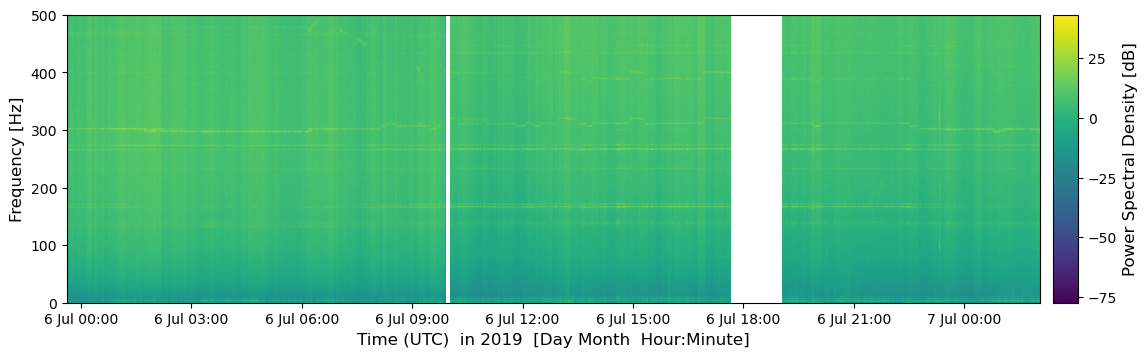

In [38]:
# plot the spectrogram
def plot_spectro(Pxx, freqs, bins, stats, 
                 t_int=False,
                 cmap="viridis",
                 vmax=None,
                 vmin=None, # matplotlib color map
                 ylim=None, 
                 yscale='linear',
                 **kwargs):
    '''plot spectrogram from pre-calculated values in calc_spec'''    
    fig = plt.figure(figsize=(6.4*2,4.8))
    ax = fig.add_axes([0.125, 0.125, 0.76, 0.6])      # main spectrogram
    ax_cbar = fig.add_axes([0.895, 0.125, 0.02, 0.6]) # colorbar
    
    # apply the ylim here - directly reduce the data
    if ylim:
        idx_low = (np.abs(freqs - ylim[0])).argmin()
        idx_high = (np.abs(freqs - ylim[1])).argmin()
        Pxx_cut = Pxx[idx_low:idx_high,:]
        freqs_cut = freqs[idx_low:idx_high]
    else:
        Pxx_cut = Pxx
        freqs_cut = freqs
    
    im = ax.imshow(10*np.log10(Pxx_cut), 
                   aspect='auto', 
                   origin='lower', 
                   cmap=cmap,
                   extent=[stats.starttime.timestamp, stats.endtime.timestamp, freqs_cut[0], freqs_cut[-1]],
                   vmax=vmax, 
                   vmin=vmin)

    cbar = plt.colorbar(im, cax=ax_cbar)
    cbar.ax.locator_params(nbins=5)
    cbar.set_label('Power Spectral Density [dB]', fontsize=12) #colorbar label
    
    # set the x-ticks
    x_tickloc, x_ticks_str, x_label = nice_x_axis(stats, bins, t_int=t_int) # functions to plot nice x-axis
    ax.set_xticks(x_tickloc)
    ax.set_xticklabels(x_ticks_str)
    ax.set_xlabel(x_label, fontsize=12) 
    
    ax.set_ylabel('Frequency [Hz]', fontsize=12)
    ax.set_yscale(yscale)
    ax.set_ylim(ylim)
    return fig

fig = plot_spectro(Pxx, freqs, bins, stats)

In [704]:
# ===== save figure =====
save_path = '/Users/graeffd/Desktop/'
save_filename = 'spec_greenland_1-500Hz_log.png'

if not os.path.exists(save_path): # create folders from save_path if not exists
    os.makedirs(save_path)

fig.savefig(os.path.join(save_path,save_filename), dpi=300, bbox_inches='tight')